In [1]:
import os
import cv2
import time
import json
import numpy as np
import threading
import queue
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def bb_iou(boxes1, boxes2):
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [3]:
frames_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Frames_LR/'
video_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/'
video_dir = '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/'
video_files = sorted(os.listdir(video_dir))
video_files = [v for v in video_files if v.endswith('.avi') and not v.endswith('_bb.avi')]
video_files = [os.path.join(video_dir, v) for v in video_files]
video_files

['/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_143836.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_144131.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_144451.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_144721.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_144947.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_174857.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_175119.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_175257.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_175435.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_175631.avi',
 '/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_175837.avi',
 '/home/ro

In [4]:
# input_height = 1080
# input_width = 1920

# output_height = 256
# output_width = 448

# for vid in range(len(video_files)):
#     video_file = video_files[vid]
#     print(video_file)
#     video_file = os.path.join(video_dir, video_file)
#     save_file = video_file.replace('Videos', 'VideosLR')
# #     save_file = os.path.join(os.path.dirname(os.path.dirname(save_file)), os.path.basename(save_file))
#     if os.path.exists(save_file):
#         continue
    
#     try:
#         os.makedirs(os.path.dirname(save_file))
#     except:
#         pass
    
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(save_file, fourcc, 30.0, (output_width, output_height))
    
#     cap = cv2.VideoCapture(video_file)
#     n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     for i in range(n_frames):
#         print(i)
#         res, frame = cap.read()
#         img = cv2.resize(frame, (output_width, output_height))
#         out.write(img)
#     out.release()
    
        

In [5]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    msk[cat == 2] = [0,0,255]
    return(msk)

In [6]:
def get_bboxes(contours, minArea, maxArea, minDst, maxDst):
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        bbox = cv2.boundingRect(cnt)
        x,y,w,h = np.array(bbox)
        if area >  minArea and area < maxArea:
            if (x > minDst) and ((x+w) < maxDst):
                bboxes.append([x,y,x+w,y+h])
    return(np.array(bboxes))

In [7]:
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # get video width
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #get video height
# width,height

In [7]:
for video_file in video_files:    
    print(video_file)
    save_file = video_file.replace('Videos', 'Videosbb')
#     video_file = video_file.replace('Videos', 'VideosLR')
    cap = cv2.VideoCapture(video_file) # load video from file
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # get video width
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #get video height

    width = 1920
    height = 1080

    new_width = int(width/4)
    new_height = int(height/4)
    
    output_height = 384
    output_width = 512    
    
    start_time = time.time()
    counter = 0


    try:
        os.makedirs(os.path.dirname(save_file))
    except:
        pass
    try:
        os.makedirs(frames_dir)
    except:
        pass
    
    json_file = save_file.replace('.avi', '.json')
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(save_file, fourcc, 30.0, (new_width, new_height))


    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(50) # background subtractor
    font = cv2.FONT_HERSHEY_SIMPLEX

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # number of frames
#     total_frames = 80
    print(total_frames)

    t_start = time.time() # start the time variable for time counting   
    old_plant_boxes = new_plant_boxes = tmp_plant_boxes = np.array([]) # inicialize the boxes vector
    old_stem_boxes = new_stem_boxes = tmp_stem_boxes = np.array([])
    video_history = {}
    
    # Ajustar de acordo com a variação na altura da câmera:
    adj_height = 55

    n_plantas = 1 # counter
    speed = 25 
    last_speed = speed
    tubete_lim = 250
    speed_avg = speed * np.ones(10)
    
    ini_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    p_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 2))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5))

    for i in range(total_frames):
        try:

            print(i)
            ret, frame = cap.read()


    #         if i < 60:
    #             continue
            frame = cv2.resize(frame, (output_width, output_height))
            img = frame.copy()
            fgmask = fgbg.apply(img)
            fgmask[:,515:] = 0
            msk = fgmask.copy()
            msk[:,:10] = 0
            msk[:,515:] = 0
            msk[:10,:] = 0
            msk[320:,:] = 0
            msk = cv2.dilate(msk, ini_kernel, iterations = 5)
            msk = (msk > 0).astype('uint8')
            mskf = np.zeros_like(msk)

            msks_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Pred3/'


            # Cria duas mascaras, a primeira para planta + tubete e a segunda apenas do tubete:
            fgmask = cv2.erode(fgmask, ini_kernel, iterations = 1)

            plant_msk = fgmask.copy()
            plant_msk[320:,:] = 0

            stem_msk = fgmask.copy()
            stem_msk[:280,:] = 0
            stem_msk[320:,:] = 0


            # Aplica um kernel vertical, para evitar que existam interrupcoes no contorno das plantas,
            # o que causaria a existencia de dois bbox:
            plant_msk = cv2.dilate(plant_msk, v_kernel, iterations = 15)
            plant_msk = cv2.dilate(plant_msk, ini_kernel, iterations = 10)
            stem_msk = cv2.dilate(stem_msk, v_kernel, iterations = 5)
            stem_msk = cv2.dilate(stem_msk, ini_kernel, iterations = 5)


            # Encontra os bbox das plantas com tubetes, que depois eh enconlhido para ficar soh a planta:
            contours, hierarchy = cv2.findContours(plant_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            new_plant_boxes = get_bboxes(contours, 500, 500000, 10, 500)
            print(new_plant_boxes)

            # Encontra os bbox dos tubetes, que depois sao movidos para a posicao do caule:
            contours, hierarchy = cv2.findContours(stem_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            new_stem_boxes = get_bboxes(contours, 10, 10000, 10, 500) 
            print(new_stem_boxes)

            if new_plant_boxes.size > 0:
                # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
                new_plant_boxes = new_plant_boxes[new_plant_boxes[:,0].argsort()[::-1]]

                # Define um criterio para os bbox que estao apenas na primeira metade do video:
                mcrit = np.ones(len(new_plant_boxes), dtype=bool)
                mcrit[new_plant_boxes[:,0] < 10] = False
                mcrit[new_plant_boxes[:,2] > frame.shape[1]/2] = False

                # Se ja existem bbox anteriores, atualiza com os correspondentes:
                if old_plant_boxes.size > 0 :
                    areas = bb_iou(new_plant_boxes, old_plant_boxes)
                    ncrit = np.where(areas.max(0) > 0)
                    acrit = areas.argmax(0)[ncrit]
                    old_plant_boxes[ncrit] = new_plant_boxes[acrit]
                    mcrit[acrit] = False

                # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
                tmp_plant_boxes = new_plant_boxes[mcrit]


            if new_stem_boxes.size > 0:
                # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
                new_stem_boxes = new_stem_boxes[new_stem_boxes[:,0].argsort()[::-1]]       

                # Define um criterio para os bbox que estao apenas na primeira metade do video:
                mcrit = np.ones(len(new_stem_boxes), dtype=bool)
                mcrit[new_stem_boxes[:,0] < 10] = False
                mcrit[new_stem_boxes[:,2] > frame.shape[1]/2] = False

                # Se ja existem bbox anteriores, atualiza com os correspondentes:
                if old_stem_boxes.size > 0 :
                    areas = bb_iou(new_stem_boxes, old_stem_boxes)
                    ncrit = np.where(areas.max(0) > 0)
                    acrit = areas.argmax(0)[ncrit]        

                    # Utiliza os bbox correspondentes para calcular a velocidade (px/frame):
                    # Obs: O calculo ocorre aqui porque eh mais estavel calcular com base nos tubetes
                    last_speed += np.mean(new_stem_boxes[acrit,0] - old_stem_boxes[ncrit,0])
                    if last_speed > 0:
                        speed_avg = np.insert(speed_avg, 0, last_speed)[:10]
                        print("Speed:" + str(speed))
                    else:
                        last_speed = speed
                    speed = int(np.mean(speed_avg))
                    old_stem_boxes[ncrit] = new_stem_boxes[acrit]
                    mcrit[acrit] = False
                # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
                tmp_stem_boxes = new_stem_boxes[mcrit]


            # Se for a primeira planta a ser identificada, atribui o bbox para plotar:
            if old_plant_boxes.size == 0 and old_stem_boxes.size == 0 :
                if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 :
                    old_stem_boxes = tmp_stem_boxes
                    old_plant_boxes = tmp_plant_boxes
                    tmp_stem_boxes = tmp_plant_boxes = np.array([])


            # Inicia o dicionario que vai salvar as coordendas dos dois bbox para cada planta:
            frame_str = {}
            if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
                # Garante que os bbox da planta e do caule sao da mesma planta (intersectam):
                areas = bb_iou(old_plant_boxes, old_stem_boxes)
                nidx = areas.argmax(1)

                for idx, ix in enumerate(nidx):
                    sbb = old_stem_boxes[ix].copy()
                    if areas.max(1)[idx] > 0 and (sbb[0] > 10) and (frame.shape[1] - sbb[2]) > 10:
                        tubete_lim = np.min([tubete_lim, sbb[1]])
                        sbb[1] = tubete_lim + adj_height
                        # Para cada bbox da planta realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                        bb = old_plant_boxes[idx].copy()
                        bb[3] = sbb[1]

                        mskf = cv2.rectangle(mskf,(bb[0], bb[1] + 30), (bb[2], bb[3] - 40),(1), -1)
#                         mskf = cv2.rectangle(mskf,(bb[0], bb[1] + 30), (bb[2], sbb[3]),(3), 5)
                        mskf = cv2.rectangle(mskf,(sbb[0], sbb[1] - 40),(sbb[2], sbb[3]),(2), -1)

                        frame = cv2.rectangle(frame,(bb[0], bb[1]), (bb[2], bb[3]),(0,0,255), 2)
                        cv2.putText(frame, 'P{}'.format(idx + n_plantas),(int(np.mean(bb[[0,2]])), bb[1]), font, 1,(255,255,255),2,cv2.LINE_AA)

                        # Para cada bbox do caule realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                        xm = int(np.mean(sbb[[0,2]]))
                        ym = int(np.mean(sbb[[1,3]]))
                        sbb[[0,2]] = xm + np.array([-20,20])
                        sbb[[1,3]] = [sbb[1] - 20, sbb[1]]                    
                        msk = cv2.rectangle(msk,(sbb[0], sbb[1]),(sbb[2], sbb[3] + 40),2, -1)                    
                        frame = cv2.rectangle(frame,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(255,0,0), 2)
                        cv2.putText(frame, 'P{}'.format(idx + n_plantas),(xm, sbb[3]), font, 1,(255,255,255),2,cv2.LINE_AA)
                        frame_str['P{}'.format(idx + n_plantas)] = {'Plant':bb.tolist(), 'Stem':sbb.tolist(), }


            # Adiciona ao dicionario do video as informacoes desse frame:
            video_history['Frame{:04d}'.format(i)] = frame_str

            # Nessa parte vou adicionar o outro modelo, que vai fazer a classificacao:
            # classificar(frame, planta)

            # Se existem novos bbox, adiciona ao conjunto que sera avaliado no proximo frame:
            if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 and tmp_plant_boxes.size == tmp_stem_boxes.size:
                old_stem_boxes = np.concatenate([tmp_stem_boxes, old_stem_boxes])
                old_plant_boxes = np.concatenate([tmp_plant_boxes, old_plant_boxes])

            # Realiza a predicao da posicao de cada bbox no proximo frame, com base na velocidade instantanea:
            if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
                old_stem_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
                old_stem_boxes = old_stem_boxes[old_stem_boxes[:,0].argsort()[::-1]]

                old_plant_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
                old_plant_boxes = old_plant_boxes[old_plant_boxes[:,0].argsort()[::-1]]

                # Remove os bbox que estarao fora da imagem, e conta como uma nova planta:
                # Obs: Esse sera o momento de enviar o controle com a classificacao da planta
                fcrit = old_stem_boxes[:,2] < frame.shape[1]
                if not fcrit.all():
                    old_plant_boxes = old_plant_boxes[fcrit]
                    old_stem_boxes = old_stem_boxes[fcrit]
                    n_plantas += 1         


            # Estou salvando apenas os frames com planta e movimento detectados:
            t_now = time.time()
            fps = i /(t_now - t_start)
            if i % 10 == 0:
                print('Running at {} FPS'.format(fps))

    #         out.write(cv2.resize(frame, (new_width, new_height)))


            if last_speed > 10 and len(frame_str) >= np.max([1,len(new_stem_boxes)]):
                print(frame_str)

    #             f_name = os.path.basename(video_file[:-4]) + '_F{:04d}'.format(i)
    #             jpg_name = os.path.join(frames_dir, f_name + '.jpg')
    #             cv2.imwrite(jpg_name, img)

    #             png_name = os.path.join(frames_dir, f_name + '.png')
    #             cv2.imwrite(png_name, msk)

    #             png_col_name = os.path.join(frames_dir, f_name + '_col.png')
    #             cv2.imwrite(png_col_name, colorir(msk))

                vf = os.path.basename(video_file[:-4]).replace('eCAM_video_', '')
                cv2.imwrite(msks_dir + vf + '_F{:04d}.png'.format(i), mskf)
                cv2.imwrite(msks_dir + vf + '_F{:04d}.jpg'.format(i), img)

        except:
            continue

    print("Fineshed Saving Video")
#     out.release()
    
#     with open(json_file, 'w') as outfile:
#         json.dump(video_history, outfile)


/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20180917_143836.avi
222
0
[]
[]
Running at 0.0 FPS
1
[]
[]
2
[]
[]
3
[]
[]
4
[]
[]
5
[]
[]
6
[]
[]
7
[]
[]
8
[]
[]
9
[]
[]
10
[]
[]
Running at 48.733180196289624 FPS
11
[]
[]
12
[]
[]
13
[]
[]
14
[]
[]
15
[]
[]
16
[]
[]
17
[]
[]
18
[]
[]
19
[]
[]
20
[]
[]
Running at 69.36419932244986 FPS
21
[]
[]
22
[]
[]
23
[]
[]
24
[]
[]
25
[]
[]
26
[]
[]
27
[]
[]
28
[]
[]
29
[]
[]
30
[]
[]
Running at 78.71458428862675 FPS
31
[]
[]
32
[]
[]
33
[]
[]
34
[]
[]
35
[]
[]
36
[]
[]
37
[]
[]
38
[]
[]
39
[]
[]
40
[]
[]
Running at 86.094799021497 FPS
41
[]
[]
42
[]
[]
43
[]
[]
44
[]
[]
45
[]
[]
46
[]
[]
47
[]
[]
48
[]
[]
49
[]
[]
50
[]
[]
Running at 91.50125352430999 FPS
51
[]
[]
52
[[145 273 193 356]]
[[150 298 178 331]]
{'P1': {'Plant': [145, 273, 193, 305], 'Stem': [144, 285, 184, 305]}}
53
[[153 273 195 356]]
[[158 298 180 331]]
Speed:25
54
[]
[]
55
[]
[]
56
[]
[]
57
[]
[]
58
[]
[]
59
[]
[]
60
[[320 273 356 354]]
[[325 298 341 329]]
Running

/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[104 136 225 351]]
[[150 265 183 326]]
Speed:19
{'P1': {'Plant': [455, 273, 497, 305], 'Stem': [451, 285, 491, 305]}, 'P2': {'Plant': [104, 136, 225, 305], 'Stem': [146, 285, 186, 305]}}
73
[[115 136 242 351]]
[[165 265 198 326]]
Speed:18
{'P1': {'Plant': [468, 273, 510, 305], 'Stem': [464, 285, 504, 305]}, 'P2': {'Plant': [115, 136, 242, 305], 'Stem': [161, 285, 201, 305]}}
74
[[103 138 249 339]]
[[185 265 212 314]]
Speed:17
{'P2': {'Plant': [103, 138, 249, 305], 'Stem': [178, 285, 218, 305]}}
75
[[193 142 260 339]
 [109 138 191 253]]
[[199 265 226 314]]
Speed:16
{'P2': {'Plant': [193, 142, 260, 305], 'Stem': [192, 285, 232, 305]}}
76
[[208 151 276 339]
 [128 140 205 254]]
[[213 265 240 314]]
Speed:15
{'P2': {'Plant': [208, 151, 276, 305], 'Stem': [206, 285, 246, 305]}}
77
[[149 150 284 339]]
[[227 265 255 314]]
Speed:14
{'P2': {'Plant': [149, 150, 284, 305], 'Stem': [221, 285, 261, 305]}}
78
[[189 134 289 339]]
[[242 265 269 314]]
Speed:15
{'P2': {'Plant': [189, 134, 289, 305], 'Ste

155
[[359 110 450 339]]
[[394 265 423 314]]
Speed:14
{'P4': {'Plant': [359, 110, 450, 305], 'Stem': [388, 285, 428, 305]}}
156
[[389 109 463 339]]
[[409 265 437 314]]
Speed:14
{'P4': {'Plant': [389, 109, 463, 305], 'Stem': [403, 285, 443, 305]}}
157
[[401 112 481 339]]
[[423 265 451 314]]
Speed:14
{'P4': {'Plant': [401, 112, 481, 305], 'Stem': [417, 285, 457, 305]}}
158
[]
[[451 265 480 315]]
Speed:14
{'P4': {'Plant': [415, 112, 495, 305], 'Stem': [445, 285, 485, 305]}}
159
[]
[]
160
[]
[[ 51 275  80 314]]
Running at 85.07305111150184 FPS
161
[[ 30  65 138 339]]
[[ 81 265 110 314]]
{'P5': {'Plant': [30, 65, 138, 305], 'Stem': [75, 285, 115, 305]}}
162
[[ 88  76 206 338]]
[[127 265 155 313]]
Speed:15
{'P5': {'Plant': [88, 76, 206, 305], 'Stem': [121, 285, 161, 305]}}
163
[[163  68 246 351]]
[[169 265 201 326]]
Speed:18
{'P5': {'Plant': [163, 68, 246, 305], 'Stem': [165, 285, 205, 305]}}
164
[[175  74 279 338]]
[[200 265 228 313]]
Speed:21
{'P5': {'Plant': [175, 74, 279, 305], 'Stem': [1

136
[[319 232 430 318]
 [143  94 244 351]]
[[159 265 193 326]]
Speed:20
{'P1': {'Plant': [143, 94, 244, 305], 'Stem': [156, 285, 196, 305]}}
137
[[319 232 408 313]
 [160  90 256 351]]
[[174 265 205 326]]
Speed:18
{'P1': {'Plant': [160, 90, 256, 305], 'Stem': [169, 285, 209, 305]}}
138
[[325 232 383 313]
 [180  89 266 339]]
[[193 265 220 314]]
Speed:17
{'P1': {'Plant': [180, 89, 266, 305], 'Stem': [186, 285, 226, 305]}}
139
[[193  90 276 339]]
[[208 265 235 314]]
Speed:17
{'P1': {'Plant': [193, 90, 276, 305], 'Stem': [201, 285, 241, 305]}}
140
[[330 232 367 313]
 [201  90 279 339]]
[[222 265 250 314]]
Speed:16
Running at 109.3609878353193 FPS
{'P1': {'Plant': [201, 90, 279, 305], 'Stem': [216, 285, 256, 305]}}
141
[[340 232 376 313]
 [205  95 291 339]]
[[237 265 265 314]]
Speed:15
{'P1': {'Plant': [205, 95, 291, 305], 'Stem': [231, 285, 271, 305]}}
142
[[331 232 370 313]
 [213 108 309 339]]
[[252 265 279 314]]
Speed:15
{'P1': {'Plant': [213, 108, 309, 305], 'Stem': [245, 285, 285, 305]}

[[336 142 416 343]
 [ 50  73 134 339]]
[[366 265 400 318]
 [ 79 265 108 314]]
Speed:34
200
[[378 145 464 340]
 [104  92 204 338]]
[[419 265 448 315]
 [129 265 157 313]]
Speed:34
Running at 97.65579061638712 FPS
{'P7': {'Plant': [378, 145, 464, 305], 'Stem': [413, 285, 453, 305]}, 'P8': {'Plant': [104, 92, 204, 305], 'Stem': [123, 285, 163, 305]}}
201
[[441 158 497 340]
 [128  85 230 351]]
[[448 266 477 315]
 [157 265 189 326]]
Speed:35
{'P7': {'Plant': [441, 158, 497, 305], 'Stem': [442, 285, 482, 305]}, 'P8': {'Plant': [128, 85, 230, 305], 'Stem': [153, 285, 193, 305]}}
202
[[171  76 260 339]]
[[205 265 233 314]]
Speed:34
{'P8': {'Plant': [171, 76, 260, 305], 'Stem': [199, 285, 239, 305]}}
203
[[204  91 299 339]]
[[238 265 265 314]]
Speed:35
{'P8': {'Plant': [204, 91, 299, 305], 'Stem': [231, 285, 271, 305]}}
204
[[268  78 350 339]]
[[289 265 316 314]]
Speed:37
{'P8': {'Plant': [268, 78, 350, 305], 'Stem': [282, 285, 322, 305]}}
205
[[325  80 411 352]]
[[331 265 369 327]]
Speed:38
{'P

{'P3': {'Plant': [234, 150, 313, 305], 'Stem': [263, 285, 303, 305]}}
108
[[245 152 327 339]]
[[284 265 311 314]]
Speed:16
{'P3': {'Plant': [245, 152, 327, 305], 'Stem': [277, 285, 317, 305]}}
109
[[258 140 349 343]]
[[302 265 334 318]]
Speed:16
{'P3': {'Plant': [258, 140, 349, 305], 'Stem': [298, 285, 338, 305]}}
110
[[277 140 365 352]]
[[316 265 349 327]]
Speed:16
Running at 89.40552175795249 FPS
{'P3': {'Plant': [277, 140, 365, 305], 'Stem': [312, 285, 352, 305]}}
111
[[ 18 165 119 339]
 [298 141 385 352]]
[[325 265 360 327]
 [ 25 265  55 314]]
Speed:16
112
[[ 37 162 131 339]
 [319 144 409 352]]
[[343 265 379 327]
 [ 44 265  73 314]]
Speed:15
{'P3': {'Plant': [319, 144, 409, 305], 'Stem': [341, 285, 381, 305]}, 'P4': {'Plant': [37, 162, 131, 305], 'Stem': [38, 285, 78, 305]}}
113
[[ 52 160 144 339]
 [349 151 439 352]]
[[ 59 275  88 314]
 [363 266 390 327]]
Speed:15
{'P3': {'Plant': [349, 151, 439, 305], 'Stem': [356, 285, 396, 305]}, 'P4': {'Plant': [52, 160, 144, 305], 'Stem': [53,

169
[[243 137 332 339]]
[[248 265 275 314]]
Speed:40
{'P7': {'Plant': [243, 137, 332, 305], 'Stem': [241, 285, 281, 305]}}
170
[[287 137 380 339]]
[[292 265 319 314]]
Speed:41
Running at 83.62235476890704 FPS
{'P7': {'Plant': [287, 137, 380, 305], 'Stem': [285, 285, 325, 305]}}
171
[[320 137 387 343]]
[[335 265 363 318]]
Speed:41
{'P7': {'Plant': [320, 137, 387, 305], 'Stem': [329, 285, 369, 305]}}
172
[[344 132 425 340]]
[[381 265 409 315]]
Speed:43
{'P7': {'Plant': [344, 132, 425, 305], 'Stem': [375, 285, 415, 305]}}
173
[[366 137 452 340]]
[[407 265 437 315]]
Speed:43
{'P7': {'Plant': [366, 137, 452, 305], 'Stem': [402, 285, 442, 305]}}
174
[]
[[444 265 483 319]]
Speed:41
{'P7': {'Plant': [392, 137, 478, 305], 'Stem': [443, 285, 483, 305]}}
175
[]
[]
176
[]
[]
177
[]
[]
178
[]
[]
179
[]
[]
180
[]
[]
Running at 83.43631192521646 FPS
181
[]
[]
182
[]
[]
183
[]
[]
184
[]
[]
185
[]
[]
186
[]
[]
187
[]
[]
188
[]
[]
189
[]
[]
190
[]
[]
Running at 83.12440668656225 FPS
191
[]
[]
192
[]
[]


[[220 161 337 339]]
[[294 265 321 314]]
Speed:14
Running at 86.85012788766656 FPS
{'P3': {'Plant': [220, 161, 337, 305], 'Stem': [287, 285, 327, 305]}}
131
[[249 169 352 339]]
[[308 265 336 314]]
Speed:15
{'P3': {'Plant': [249, 169, 352, 305], 'Stem': [302, 285, 342, 305]}}
132
[[290 173 370 352]]
[[323 265 355 327]]
Speed:15
{'P3': {'Plant': [290, 173, 370, 305], 'Stem': [319, 285, 359, 305]}}
133
[[329 169 413 343]]
[[336 265 369 318]]
Speed:15
{'P3': {'Plant': [329, 169, 413, 305], 'Stem': [332, 285, 372, 305]}}
134
[[341 166 463 352]]
[[346 265 382 327]]
Speed:14
135
[[355 163 492 343]]
[[360 265 394 318]]
Speed:13
{'P3': {'Plant': [355, 163, 492, 305], 'Stem': [357, 285, 397, 305]}}
136
[]
[[380 265 408 315]]
Speed:13
{'P3': {'Plant': [369, 163, 506, 305], 'Stem': [374, 285, 414, 305]}}
137
[]
[[395 265 423 315]
 [ 30 265  59 314]]
Speed:14
138
[]
[[409 265 438 315]
 [ 45 265  74 314]]
Speed:14
139
[[ 11 136 120 339]]
[[423 265 456 319]
 [ 61 265  89 314]]
Speed:14
140
[[428 158 4

[[232 132 340 339]]
[[240 265 267 314]]
Speed:39
{'P10': {'Plant': [232, 132, 340, 305], 'Stem': [233, 285, 273, 305]}}
193
[[248 117 334 339]]
[[283 265 311 314]]
Speed:39
{'P10': {'Plant': [248, 117, 334, 305], 'Stem': [277, 285, 317, 305]}}
194
[[246 119 364 352]]
[[317 265 349 327]]
Speed:39
{'P10': {'Plant': [246, 119, 364, 305], 'Stem': [313, 285, 353, 305]}}
195
[[308 127 423 352]]
[[358 266 392 327]]
Speed:40
{'P10': {'Plant': [308, 127, 423, 305], 'Stem': [355, 285, 395, 305]}}
196
[]
[[407 265 436 315]]
Speed:41
{'P10': {'Plant': [349, 127, 464, 305], 'Stem': [401, 285, 441, 305]}}
197
[]
[[422 265 451 315]]
{'P10': {'Plant': [398, 127, 513, 305], 'Stem': [450, 285, 490, 305]}}
198
[]
[[469 265 498 319]]
199
[]
[]
200
[]
[]
Running at 82.94208297680775 FPS
201
[]
[]
202
[]
[]
203
[]
[]
204
[]
[]
205
[]
[]
206
[]
[]
207
[]
[]
208
[]
[]
209
[]
[]
210
[]
[]
Running at 84.25120063176647 FPS
211
[]
[]
212
[]
[]
213
[]
[]
214
[]
[]
215
[]
[]
216
[]
[]
217
[]
[]
218
[]
[]
219
[]
[]


[]
[]
Running at 88.31621257453246 FPS
{'P3': {'Plant': [185, 273, 235, 305], 'Stem': [185, 285, 225, 305]}}
121
[]
[]
{'P3': {'Plant': [199, 273, 249, 305], 'Stem': [199, 285, 239, 305]}}
122
[]
[]
{'P3': {'Plant': [213, 273, 263, 305], 'Stem': [213, 285, 253, 305]}}
123
[]
[]
{'P3': {'Plant': [227, 273, 277, 305], 'Stem': [227, 285, 267, 305]}}
124
[]
[]
{'P3': {'Plant': [241, 273, 291, 305], 'Stem': [241, 285, 281, 305]}}
125
[[320 262 377 357]]
[[325 287 362 332]]
{'P3': {'Plant': [255, 273, 305, 305], 'Stem': [255, 285, 295, 305]}}
126
[[338 262 399 358]]
[[343 287 384 333]]
{'P3': {'Plant': [271, 273, 321, 305], 'Stem': [271, 285, 311, 305]}}
127
[[356 262 392 343]]
[[361 287 377 318]]
{'P3': {'Plant': [287, 273, 337, 305], 'Stem': [287, 285, 327, 305]}}
128
[]
[]
{'P3': {'Plant': [303, 273, 353, 305], 'Stem': [303, 285, 343, 305]}}
129
[]
[]
{'P3': {'Plant': [319, 273, 369, 305], 'Stem': [319, 285, 359, 305]}}
130
[]
[]
Running at 87.5774563100122 FPS
{'P3': {'Plant': [335, 273,

[[136 130 222 354]]
[[147 266 176 329]]
Speed:14
{'P3': {'Plant': [136, 130, 222, 305], 'Stem': [141, 285, 181, 305]}}
76
[[156 130 230 354]]
[[162 266 191 329]]
Speed:15
{'P3': {'Plant': [156, 130, 230, 305], 'Stem': [156, 285, 196, 305]}}
77
[[164 131 235 354]]
[[176 266 205 329]]
Speed:15
{'P3': {'Plant': [164, 131, 235, 305], 'Stem': [170, 285, 210, 305]}}
78
[[174 131 244 341]]
[[191 266 219 316]]
Speed:15
{'P3': {'Plant': [174, 131, 244, 305], 'Stem': [185, 285, 225, 305]}}
79
[[188 156 254 341]]
[[210 266 237 316]]
Speed:15
{'P3': {'Plant': [188, 156, 254, 305], 'Stem': [203, 285, 243, 305]}}
80
[[195 140 283 341]]
[[224 266 251 316]]
Speed:15
Running at 57.27651411504623 FPS
{'P3': {'Plant': [195, 140, 283, 305], 'Stem': [217, 285, 257, 305]}}
81
[[203 134 293 341]]
[[239 265 266 316]]
Speed:15
{'P3': {'Plant': [203, 134, 293, 305], 'Stem': [232, 285, 272, 305]}}
82
[[213 132 302 341]]
[[253 267 281 316]]
Speed:16
{'P3': {'Plant': [213, 132, 302, 305], 'Stem': [247, 285, 287, 3

{'P2': {'Plant': [238, 107, 334, 305], 'Stem': [236, 285, 276, 305]}}
44
[[246 107 351 341]]
[[254 265 281 316]]
Speed:10
{'P2': {'Plant': [246, 107, 351, 305], 'Stem': [247, 285, 287, 305]}}
45
[[255 108 363 341]]
[[264 265 292 316]]
Speed:11
46
[[267 114 372 341]]
[[279 267 306 316]]
Speed:11
{'P2': {'Plant': [267, 114, 372, 305], 'Stem': [272, 285, 312, 305]}}
47
[[280 114 386 341]]
[[290 267 318 316]]
Speed:11
{'P2': {'Plant': [280, 114, 386, 305], 'Stem': [284, 285, 324, 305]}}
48
[[286 106 393 341]]
[[297 267 325 316]]
Speed:11
49
[[293 114 398 341]]
[[302 267 330 316]]
Speed:11
50
[[298 113 401 341]]
[[306 267 335 316]]
Speed:10
Running at 54.48472667640756 FPS
51
[[305 107 415 354]]
[[316 267 347 329]]
Speed:9
52
[[319 110 423 354]]
[[327 267 358 329]]
Speed:9
{'P2': {'Plant': [319, 110, 423, 305], 'Stem': [322, 285, 362, 305]}}
53
[[329 129 427 354]]
[[338 267 370 329]]
Speed:9
{'P2': {'Plant': [329, 129, 427, 305], 'Stem': [334, 285, 374, 305]}}
54
[[342 128 425 354]]
[[349 2

24
[[287 130 379 342]]
[[292 267 320 317]]
Speed:14
{'P1': {'Plant': [287, 130, 379, 305], 'Stem': [286, 285, 326, 305]}}
25
[[302 132 399 341]]
[[307 267 336 316]]
Speed:14
{'P1': {'Plant': [302, 132, 399, 305], 'Stem': [301, 285, 341, 305]}}
26
[[317 160 425 355]]
[[322 267 360 330]]
Speed:15
{'P1': {'Plant': [317, 160, 425, 305], 'Stem': [321, 285, 361, 305]}}
27
[[331 157 443 354]]
[[336 265 368 329]]
Speed:15
{'P1': {'Plant': [331, 157, 443, 305], 'Stem': [332, 285, 372, 305]}}
28
[[346 129 447 354]]
[[351 267 383 329]]
Speed:14
{'P1': {'Plant': [346, 129, 447, 305], 'Stem': [347, 285, 387, 305]}}
29
[[360 126 444 354]]
[[365 278 393 329]]
Speed:14
{'P1': {'Plant': [360, 126, 444, 305], 'Stem': [359, 285, 399, 305]}}
30
[[375 125 443 342]]
[[380 268 409 317]]
Speed:14
Running at 49.46364025534314 FPS
{'P1': {'Plant': [375, 125, 443, 305], 'Stem': [374, 285, 414, 305]}}
31
[[387 125 442 346]]
[[394 268 427 321]]
Speed:14
{'P1': {'Plant': [387, 125, 442, 305], 'Stem': [390, 285, 430

[[181  88 280 341]]
[[223 265 250 316]]
Speed:15
Running at 57.666068370721675 FPS
{'P1': {'Plant': [181, 88, 280, 305], 'Stem': [216, 285, 256, 305]}}
21
[[202  85 295 341]]
[[238 266 265 316]]
Speed:15
{'P1': {'Plant': [202, 85, 295, 305], 'Stem': [231, 285, 271, 305]}}
22
[[222  84 314 341]]
[[253 267 280 316]]
Speed:15
{'P1': {'Plant': [222, 84, 314, 305], 'Stem': [246, 285, 286, 305]}}
23
[[242  85 336 341]]
[[268 267 295 316]]
Speed:15
{'P1': {'Plant': [242, 85, 336, 305], 'Stem': [261, 285, 301, 305]}}
24
[[272  85 361 341]]
[[282 267 309 316]]
Speed:15
{'P1': {'Plant': [272, 85, 361, 305], 'Stem': [275, 285, 315, 305]}}
25
[[292  86 370 341]]
[[297 267 325 316]]
Speed:14
{'P1': {'Plant': [292, 86, 370, 305], 'Stem': [291, 285, 331, 305]}}
26
[[303  91 389 354]]
[[312 267 345 329]]
Speed:14
{'P1': {'Plant': [303, 91, 389, 305], 'Stem': [308, 285, 348, 305]}}
27
[[312  90 408 354]]
[[322 267 359 329]]
Speed:14
28
[[323  88 419 357]]
[[336 267 380 332]]
Speed:14
{'P1': {'Plant': [

[]
[[ 24 265  59 320]]
85
[]
[[ 38 265  70 320]]
86
[]
[[ 53 266  82 316]]
87
[[ 26 174 109 341]]
[[ 65 266  94 316]]
{'P4': {'Plant': [26, 174, 109, 305], 'Stem': [59, 285, 99, 305]}}
88
[[ 44 176 120 341]]
[[ 76 265 105 316]]
Speed:14
{'P4': {'Plant': [44, 176, 120, 305], 'Stem': [70, 285, 110, 305]}}
89
[[ 75 166 155 341]]
[[ 88 265 117 316]]
Speed:14
{'P4': {'Plant': [75, 166, 155, 305], 'Stem': [82, 285, 122, 305]}}
90
[[ 90 163 175 341]]
[[100 265 128 316]]
Speed:14
Running at 53.800342594950806 FPS
{'P4': {'Plant': [90, 163, 175, 305], 'Stem': [94, 285, 134, 305]}}
91
[[110 159 209 341]]
[[119 266 148 316]]
Speed:13
{'P4': {'Plant': [110, 159, 209, 305], 'Stem': [113, 285, 153, 305]}}
92
[[128 159 236 345]]
[[135 266 168 320]]
Speed:14
{'P4': {'Plant': [128, 159, 236, 305], 'Stem': [131, 285, 171, 305]}}
93
[[141 172 251 354]]
[[147 266 176 329]]
Speed:14
{'P4': {'Plant': [141, 172, 251, 305], 'Stem': [141, 285, 181, 305]}}
94
[[156 168 258 354]]
[[161 266 190 329]]
Speed:14
{'P

[[168 136 272 354]]
[[441 267 476 321]
 [173 267 205 329]]
Speed:15
{'P2': {'Plant': [409, 147, 506, 305], 'Stem': [438, 285, 478, 305]}, 'P3': {'Plant': [168, 136, 272, 305], 'Stem': [169, 285, 209, 305]}}
50
[[174 136 278 345]]
[[453 267 482 318]
 [179 267 212 320]]
Speed:15
Running at 50.79878140206586 FPS
51
[[184 137 279 341]]
[[458 267 487 318]
 [189 267 217 316]]
Speed:14
52
[[190 139 282 341]]
[[463 267 493 318]
 [195 267 225 316]]
Speed:13
53
[[200 138 298 341]]
[[206 265 233 316]]
Speed:12
{'P2': {'Plant': [442, 147, 539, 305], 'Stem': [463, 285, 503, 305]}, 'P3': {'Plant': [200, 138, 298, 305], 'Stem': [199, 285, 239, 305]}}
54
[[203 136 312 341]]
[[217 265 244 316]]
Speed:12
{'P3': {'Plant': [203, 136, 312, 305], 'Stem': [210, 285, 250, 305]}}
55
[[202 134 322 341]]
[[228 265 255 316]]
Speed:12
{'P3': {'Plant': [202, 134, 322, 305], 'Stem': [221, 285, 261, 305]}}
56
[[194 134 328 341]]
[[239 267 267 316]
 [ 11 265  46 320]]
Speed:11
57
[[190 135 330 341]]
[[250 267 278 316]

[[244 139 361 341]]
[[ 22 278  44 316]
 [266 265 294 316]]
Speed:16
19
[[280 140 384 341]]
[[285 267 313 316]
 [ 35 265  68 320]]
Speed:15
20
[[291 139 400 341]]
[[296 267 323 316]
 [ 47 265  76 316]]
Speed:15
Running at 48.83619578006209 FPS
21
[[ 50 148 133 345]
 [302 139 408 341]]
[[307 267 336 316]
 [ 59 266  88 320]]
Speed:15
22
[[305 137 422 354]
 [ 68 137 179 341]]
[[322 267 354 329]
 [ 75 265 104 316]]
Speed:14
{'P1': {'Plant': [305, 137, 422, 305], 'Stem': [318, 285, 358, 305]}, 'P2': {'Plant': [68, 137, 179, 305], 'Stem': [69, 285, 109, 305]}}
23
[[301 134 432 354]
 [ 84 133 209 341]]
[[337 267 369 329]
 [ 91 265 119 316]]
Speed:14
{'P1': {'Plant': [301, 134, 432, 305], 'Stem': [333, 285, 373, 305]}, 'P2': {'Plant': [84, 133, 209, 305], 'Stem': [85, 285, 125, 305]}}
24
[[303 133 434 354]
 [ 96 130 225 341]]
[[348 267 380 329]
 [102 265 131 316]]
Speed:14
{'P1': {'Plant': [303, 133, 434, 305], 'Stem': [344, 285, 384, 305]}, 'P2': {'Plant': [96, 130, 225, 305], 'Stem': [96, 285

11
[[133  92 224 341]]
[[167 266 197 316]]
Speed:22
{'P1': {'Plant': [133, 92, 224, 305], 'Stem': [162, 285, 202, 305]}}
12
[[143  93 235 341]]
[[183 266 211 316]]
Speed:21
{'P1': {'Plant': [143, 93, 235, 305], 'Stem': [177, 285, 217, 305]}}
13
[[165 104 255 341]]
[[199 266 227 316]]
Speed:20
{'P1': {'Plant': [165, 104, 255, 305], 'Stem': [193, 285, 233, 305]}}
14
[[173 111 273 341]]
[[214 266 242 316]]
Speed:19
{'P1': {'Plant': [173, 111, 273, 305], 'Stem': [208, 285, 248, 305]}}
15
[[192  94 288 341]]
[[229 266 257 316]]
Speed:18
{'P1': {'Plant': [192, 94, 288, 305], 'Stem': [223, 285, 263, 305]}}
16
[[208  94 308 341]]
[[252 266 280 316]]
Speed:17
{'P1': {'Plant': [208, 94, 308, 305], 'Stem': [246, 285, 286, 305]}}
17
[[223  93 323 341]]
[[259 267 288 316]]
Speed:17
18
[[ 17 171 112 341]
 [248  94 341 341]]
[[ 30 283  48 316]
 [271 267 299 316]]
Speed:15
19
[[ 27 171 120 341]
 [260  95 356 341]]
[[279 267 306 316]
 [ 33 265  62 316]]
Speed:15
20
[[ 33 171 127 341]
 [251  94 351 341]

Speed:15
{'P4': {'Plant': [255, 155, 355, 305], 'Stem': [256, 285, 296, 305]}}
79
[[275 154 351 342]]
[[280 268 308 317]]
Speed:14
{'P4': {'Plant': [275, 154, 351, 305], 'Stem': [274, 285, 314, 305]}}
80
[[274 152 341 342]]
[[296 267 323 317]]
Speed:15
Running at 54.42504252864764 FPS
{'P4': {'Plant': [274, 152, 341, 305], 'Stem': [289, 285, 329, 305]}}
81
[[268 153 357 354]]
[[311 267 342 329]]
Speed:16
{'P4': {'Plant': [268, 153, 357, 305], 'Stem': [306, 285, 346, 305]}}
82
[[265 163 372 354]]
[[326 267 357 329]]
Speed:16
{'P4': {'Plant': [265, 163, 372, 305], 'Stem': [321, 285, 361, 305]}}
83
[[273 164 385 342]]
[[341 267 369 317]]
Speed:15
{'P4': {'Plant': [273, 164, 385, 305], 'Stem': [335, 285, 375, 305]}}
84
[[285 164 400 355]
 [ 13 139  97 341]]
[[356 267 385 330]
 [ 19 265  49 316]]
Speed:15
85
[[310 165 416 342]
 [ 29 135 112 341]]
[[371 267 400 317]
 [ 35 265  65 316]]
Speed:16
{'P4': {'Plant': [310, 165, 416, 305], 'Stem': [365, 285, 405, 305]}, 'P5': {'Plant': [29, 135, 11

[[ 68  88 156 353]]
[[113 265 141 328]]
Speed:24
{'P1': {'Plant': [68, 88, 156, 305], 'Stem': [107, 285, 147, 305]}}
10
[[ 88  88 182 354]]
[[138 265 166 329]]
Speed:24
Running at 50.022648098168 FPS
{'P1': {'Plant': [88, 88, 182, 305], 'Stem': [132, 285, 172, 305]}}
11
[[119  87 220 354]]
[[163 265 190 329]]
Speed:24
{'P1': {'Plant': [119, 87, 220, 305], 'Stem': [156, 285, 196, 305]}}
12
[[162  88 256 354]]
[[188 265 215 329]]
Speed:24
{'P1': {'Plant': [162, 88, 256, 305], 'Stem': [181, 285, 221, 305]}}
13
[[200  98 281 354]]
[[206 265 233 329]]
Speed:24
{'P1': {'Plant': [200, 98, 281, 305], 'Stem': [199, 285, 239, 305]}}
14
[[225  98 313 354]]
[[230 265 257 329]]
Speed:23
{'P1': {'Plant': [225, 98, 313, 305], 'Stem': [223, 285, 263, 305]}}
15
[[249  91 333 354]]
[[255 265 282 329]]
Speed:23
{'P1': {'Plant': [249, 91, 333, 305], 'Stem': [248, 285, 288, 305]}}
16
[[270  88 363 354]]
[[279 265 306 329]]
Speed:23
{'P1': {'Plant': [270, 88, 363, 305], 'Stem': [272, 285, 312, 305]}}
17
[[2

[[317  79 407 356]]
[[364 265 392 331]]
Speed:14
{'P5': {'Plant': [317, 79, 407, 305], 'Stem': [358, 285, 398, 305]}}
77
[[351  90 429 357]]
[[383 265 411 332]]
Speed:16
{'P5': {'Plant': [351, 90, 429, 305], 'Stem': [377, 285, 417, 305]}}
78
[[376  90 467 357]]
[[408 265 436 332]]
Speed:17
{'P5': {'Plant': [376, 90, 467, 305], 'Stem': [402, 285, 442, 305]}}
79
[]
[[433 265 461 333]]
Speed:18
{'P5': {'Plant': [401, 90, 492, 305], 'Stem': [427, 285, 467, 305]}}
80
[]
[[458 265 486 333]]
Speed:19
Running at 52.91726772269589 FPS
{'P5': {'Plant': [426, 90, 517, 305], 'Stem': [452, 285, 492, 305]}}
81
[]
[]
82
[]
[]
83
[]
[]
84
[]
[]
85
[]
[]
86
[]
[]
87
[]
[]
88
[]
[]
89
[]
[]
90
[]
[]
Running at 55.77862399944205 FPS
91
[]
[]
92
[]
[]
93
[]
[]
94
[]
[]
95
[]
[]
96
[]
[]
97
[]
[]
98
[]
[]
99
[]
[]
100
[]
[]
Running at 58.11729947901908 FPS
101
[]
[]
102
[]
[]
103
[]
[]
104
[]
[]
105
[]
[]
106
[]
[]
107
[]
[]
108
[]
[]
109
[]
[]
110
[]
[]
Running at 59.38556217063507 FPS
111
[]
[]
112
[]
[]

Speed:20
Running at 53.54657519531375 FPS
{'P5': {'Plant': [233, 67, 330, 305], 'Stem': [243, 285, 283, 305]}}
71
[[249  71 346 354]]
[[263 265 290 329]]
Speed:18
{'P5': {'Plant': [249, 71, 346, 305], 'Stem': [256, 285, 296, 305]}}
72
[[258  75 354 355]]
[[275 265 302 330]]
Speed:17
{'P5': {'Plant': [258, 75, 354, 305], 'Stem': [268, 285, 308, 305]}}
73
[[270  77 343 355]]
[[281 265 308 330]]
Speed:16
74
[[267  74 348 356]]
[[291 265 318 331]]
Speed:14
{'P5': {'Plant': [267, 74, 348, 305], 'Stem': [284, 285, 324, 305]}}
75
[[303  76 375 355]]
[[316 265 343 330]]
Speed:13
{'P5': {'Plant': [303, 76, 375, 305], 'Stem': [309, 285, 349, 305]}}
76
[[327  79 415 356]]
[[341 265 368 331]]
Speed:13
{'P5': {'Plant': [327, 79, 415, 305], 'Stem': [334, 285, 374, 305]}}
77
[[346  88 443 356]]
[[359 265 387 331]]
Speed:14
{'P5': {'Plant': [346, 88, 443, 305], 'Stem': [353, 285, 393, 305]}}
78
[[371  69 470 357]]
[[384 265 412 332]]
Speed:15
{'P5': {'Plant': [371, 69, 470, 305], 'Stem': [378, 285, 41

Speed:16
{'P3': {'Plant': [348, 160, 431, 305], 'Stem': [380, 285, 420, 305]}, 'P4': {'Plant': [173, 161, 293, 305], 'Stem': [178, 285, 218, 305]}}
49
[[172 161 313 354]
 [378 156 482 357]]
[[411 265 439 332]
 [209 265 236 329]]
Speed:15
{'P3': {'Plant': [378, 156, 482, 305], 'Stem': [405, 285, 445, 305]}, 'P4': {'Plant': [172, 161, 313, 305], 'Stem': [202, 285, 242, 305]}}
50
[[178 166 315 354]]
[[436 265 464 332]
 [233 265 260 329]]
Speed:16
Running at 54.79425425774321 FPS
{'P3': {'Plant': [402, 156, 506, 305], 'Stem': [430, 285, 470, 305]}, 'P4': {'Plant': [178, 166, 315, 305], 'Stem': [226, 285, 266, 305]}}
51
[[199 165 307 354]]
[[460 265 489 333]
 [258 265 285 329]]
Speed:18
{'P3': {'Plant': [427, 156, 531, 305], 'Stem': [454, 285, 494, 305]}, 'P4': {'Plant': [199, 165, 307, 305], 'Stem': [251, 285, 291, 305]}}
52
[[229 163 324 355]]
[[282 265 309 330]]
Speed:20
{'P4': {'Plant': [229, 163, 324, 305], 'Stem': [275, 285, 315, 305]}}
53
[[239 159 349 355]]
[[305 265 334 330]]
Speed

32
[[340 137 417 356]
 [ 56 129 156 354]]
[[354 265 382 331]
 [ 62 265  90 329]]
Speed:22
{'P2': {'Plant': [340, 137, 417, 305], 'Stem': [348, 285, 388, 305]}, 'P3': {'Plant': [56, 129, 156, 305], 'Stem': [56, 285, 96, 305]}}
33
[[322 137 439 357]
 [ 80 130 180 353]]
[[378 265 406 332]
 [ 85 265 113 328]]
Speed:22
{'P2': {'Plant': [322, 137, 439, 305], 'Stem': [372, 285, 412, 305]}, 'P3': {'Plant': [80, 130, 180, 305], 'Stem': [79, 285, 119, 305]}}
34
[[320 134 478 357]
 [105 130 190 353]]
[[402 265 430 332]
 [110 265 137 328]]
Speed:22
{'P2': {'Plant': [320, 134, 478, 305], 'Stem': [396, 285, 436, 305]}, 'P3': {'Plant': [105, 130, 190, 305], 'Stem': [103, 285, 143, 305]}}
35
[[121 134 204 353]]
[[426 265 455 332]
 [135 265 162 328]]
Speed:22
{'P2': {'Plant': [345, 134, 503, 305], 'Stem': [420, 285, 460, 305]}, 'P3': {'Plant': [121, 134, 204, 305], 'Stem': [128, 285, 168, 305]}}
36
[[125 143 213 354]]
[[445 265 474 333]
 [153 265 181 329]]
Speed:23
{'P2': {'Plant': [369, 134, 527, 305]

[[144 128 248 354]
 [369  99 459 357]
 [ 23  95 110 354]]
[[411 265 439 332]
 [206 265 233 329]
 [ 61 265  90 329]]
Speed:17
{'P1': {'Plant': [369, 99, 459, 305], 'Stem': [405, 285, 445, 305]}, 'P2': {'Plant': [144, 128, 248, 305], 'Stem': [199, 285, 239, 305]}, 'P3': {'Plant': [23, 95, 110, 305], 'Stem': [55, 285, 95, 305]}}
25
[[ 68 226 116 353]
 [171 116 256 354]
 [ 38  97 132 225]
 [393  89 483 357]]
[[418 265 446 332]
 [213 265 240 329]
 [ 73 265 101 328]]
Speed:16
26
[[182 116 265 354]
 [ 50  98 137 353]
 [409  95 495 357]]
[[424 265 452 332]
 [219 265 246 329]
 [ 85 265 113 328]]
Speed:16
27
[[184 127 280 355]
 [395  99 493 358]
 [ 52  98 166 354]]
[[442 265 470 333]
 [237 265 264 330]
 [104 265 132 329]]
Speed:15
{'P1': {'Plant': [395, 99, 493, 305], 'Stem': [436, 285, 476, 305]}, 'P2': {'Plant': [184, 127, 280, 305], 'Stem': [230, 285, 270, 305]}, 'P3': {'Plant': [52, 98, 166, 305], 'Stem': [98, 285, 138, 305]}}
28
[[117 227 165 354]
 [ 82  98 286 355]]
[[447 265 476 333]
 [24

[[276 113 364 354]]
[[ 30 266  57 329]
 [308 265 336 329]]
Speed:15
{'P6': {'Plant': [276, 113, 364, 305], 'Stem': [302, 285, 342, 305]}, 'P7': {'Plant': [139, 253, 177, 305], 'Stem': [133, 285, 173, 305]}}
93
[[308 111 385 354]
 [ 38 101 136 353]]
[[336 265 363 329]
 [ 57 265  82 328]]
Speed:16
{'P6': {'Plant': [308, 111, 385, 305], 'Stem': [329, 285, 369, 305]}, 'P7': {'Plant': [165, 253, 203, 305], 'Stem': [159, 285, 199, 305]}}
94
[[313 114 397 356]
 [ 57  96 159 354]
 [125   0 168  41]]
[[354 265 382 331]
 [ 76 265 103 329]]
Speed:16
{'P6': {'Plant': [313, 114, 397, 305], 'Stem': [348, 285, 388, 305]}, 'P7': {'Plant': [193, 253, 231, 305], 'Stem': [187, 285, 227, 305]}, 'P8': {'Plant': [57, 96, 159, 305], 'Stem': [69, 285, 109, 305]}}
95
[[349 109 437 357]
 [ 94  94 191 354]]
[[378 265 406 332]
 [100 265 127 329]]
Speed:15
{'P6': {'Plant': [349, 109, 437, 305], 'Stem': [372, 285, 412, 305]}, 'P7': {'Plant': [212, 253, 250, 305], 'Stem': [206, 285, 246, 305]}, 'P8': {'Plant': [94, 

[[214  97 309 337]]
[[224 275 247 312]]
Speed:16
Running at 68.12781078928892 FPS
{'P3': {'Plant': [214, 97, 309, 305], 'Stem': [215, 285, 255, 305]}}
81
[[233  95 335 338]]
[[242 280 262 313]]
Speed:17
{'P3': {'Plant': [233, 95, 335, 305], 'Stem': [232, 285, 272, 305]}}
82
[[251  95 369 338]]
[[256 275 280 313]]
Speed:17
{'P3': {'Plant': [251, 95, 369, 305], 'Stem': [248, 285, 288, 305]}}
83
[[263  99 401 338]]
[[268 275 296 313]]
Speed:17
{'P3': {'Plant': [263, 99, 401, 305], 'Stem': [262, 285, 302, 305]}}
84
[[282  99 422 338]]
[[290 276 314 313]]
Speed:16
{'P3': {'Plant': [282, 99, 422, 305], 'Stem': [282, 285, 322, 305]}}
85
[[294  97 422 338]]
[[299 276 322 313]]
Speed:17
86
[[312 102 427 338]]
[[320 268 345 313]]
Speed:17
{'P3': {'Plant': [312, 102, 427, 305], 'Stem': [312, 285, 352, 305]}}
87
[[326 101 427 351]]
[[ 23 274  49 313]
 [339 269 364 326]]
Speed:17
88
[[316  96 402 351]]
[[356 275 381 326]
 [ 42 274  70 313]]
Speed:18
89
[[309  96 416 339]]
[[372 276 396 314]
 [ 60 2

[[211  94 306 338]]
[[263 266 291 313]]
Speed:21
{'P2': {'Plant': [211, 94, 306, 305], 'Stem': [257, 285, 297, 305]}}
64
[[247  90 337 338]]
[[287 266 314 313]]
Speed:21
{'P2': {'Plant': [247, 90, 337, 305], 'Stem': [280, 285, 320, 305]}}
65
[[277  90 381 338]]
[[314 266 337 313]]
Speed:22
{'P2': {'Plant': [277, 90, 381, 305], 'Stem': [305, 285, 345, 305]}}
66
[[315  89 426 338]]
[[334 267 362 313]]
Speed:23
{'P2': {'Plant': [315, 89, 426, 305], 'Stem': [328, 285, 368, 305]}}
67
[[342  91 455 339]]
[[352 268 380 314]
 [ 16 266  41 313]]
Speed:23
68
[[372  94 481 339]]
[[377 276 404 314]
 [ 42 275  66 313]]
Speed:23
69
[]
[[401 276 429 315]
 [ 67 265  95 312]]
Speed:23
70
[[ 34  80 179 337]]
[[429 276 454 315]
 [ 93 266 121 312]]
Speed:23
Running at 66.55699620699318 FPS
71
[[ 81  77 225 337]]
[[119 275 146 312]
 [454 271 478 315]]
Speed:23
{'P2': {'Plant': [449, 94, 558, 305], 'Stem': [446, 285, 486, 305]}, 'P3': {'Plant': [81, 77, 225, 305], 'Stem': [112, 285, 152, 305]}}
72
[[138  85

[[117  84 187 337]]
[[137 275 160 312]]
Speed:21
{'P1': {'Plant': [117, 84, 187, 305], 'Stem': [128, 285, 168, 305]}}
46
[[142  90 216 338]]
[[153 281 171 313]]
Speed:20
{'P1': {'Plant': [142, 90, 216, 305], 'Stem': [142, 285, 182, 305]}}
47
[[160  88 245 337]]
[[166 268 190 312]]
Speed:19
{'P1': {'Plant': [160, 88, 245, 305], 'Stem': [158, 285, 198, 305]}}
48
[[178  81 269 338]]
[[184 275 212 313]]
Speed:18
{'P1': {'Plant': [178, 81, 269, 305], 'Stem': [178, 285, 218, 305]}}
49
[[191  81 300 337]]
[[197 275 224 312]]
Speed:17
{'P1': {'Plant': [191, 81, 300, 305], 'Stem': [190, 285, 230, 305]}}
50
[[209 209 257 338]
 [273  97 362 232]]
[[215 275 239 313]]
Speed:16
Running at 67.59014911942575 FPS
{'P1': {'Plant': [209, 209, 257, 305], 'Stem': [207, 285, 247, 305]}}
51
[[222 209 270 338]
 [285 100 385 235]]
[[231 281 251 313]]
Speed:16
{'P1': {'Plant': [222, 209, 270, 305], 'Stem': [221, 285, 261, 305]}}
52
[[240  82 386 338]]
[[250 275 273 313]]
Speed:16
{'P1': {'Plant': [240, 82, 386,

103
[[145  98 251 338]]
[[448 282 471 315]
 [209 275 236 313]]
Speed:16
{'P3': {'Plant': [391, 83, 500, 305], 'Stem': [439, 285, 479, 305]}, 'P4': {'Plant': [145, 98, 251, 305], 'Stem': [202, 285, 242, 305]}}
104
[[169  95 270 338]]
[[466 282 489 316]
 [231 281 251 313]]
Speed:16
{'P3': {'Plant': [409, 83, 518, 305], 'Stem': [457, 285, 497, 305]}, 'P4': {'Plant': [169, 95, 270, 305], 'Stem': [221, 285, 261, 305]}}
105
[[182  96 282 338]]
[[243 276 267 313]]
Speed:16
{'P4': {'Plant': [182, 96, 282, 305], 'Stem': [235, 285, 275, 305]}}
106
[[207  97 301 338]]
[[258 275 285 313]]
Speed:16
{'P4': {'Plant': [207, 97, 301, 305], 'Stem': [251, 285, 291, 305]}}
107
[[230  99 313 338]]
[[270 275 293 313]]
Speed:16
{'P4': {'Plant': [230, 99, 313, 305], 'Stem': [261, 285, 301, 305]}}
108
[[271  96 331 338]]
[[292 276 316 313]]
Speed:15
{'P4': {'Plant': [271, 96, 331, 305], 'Stem': [284, 285, 324, 305]}}
109
[[296  95 364 338]]
[[311 269 334 313]]
Speed:16
{'P4': {'Plant': [296, 95, 364, 305], 'St

64
[[316 187 364 351]
 [329  19 386 144]]
[[321 268 348 326]]
Speed:15
{'P2': {'Plant': [316, 187, 364, 305], 'Stem': [314, 285, 354, 305]}}
65
[[334 185 382 339]
 [350  20 412 142]]
[[339 268 367 314]]
Speed:16
{'P2': {'Plant': [334, 185, 382, 305], 'Stem': [333, 285, 373, 305]}}
66
[[347 186 395 339]
 [364  25 430 132]]
[[ 16 275  40 311]
 [352 269 379 314]]
Speed:16
67
[[365 186 414 339]
 [ 24 102 109 336]
 [381  26 464 132]]
[[370 276 397 314]
 [ 35 267  63 311]]
Speed:16
68
[[377 185 426 339]
 [ 35 104 126 336]
 [392  21 479 136]]
[[382 276 409 314]
 [ 48 275  71 311]]
Speed:15
{'P2': {'Plant': [377, 185, 426, 305], 'Stem': [375, 285, 415, 305]}, 'P3': {'Plant': [35, 104, 126, 305], 'Stem': [39, 285, 79, 305]}}
69
[[396 191 444 340]
 [ 61  98 147 336]
 [398  22 480 142]]
[[404 276 428 315]
 [ 67 275  94 311]]
Speed:15
{'P2': {'Plant': [396, 191, 444, 305], 'Stem': [396, 285, 436, 305]}, 'P3': {'Plant': [61, 98, 147, 305], 'Stem': [60, 285, 100, 305]}}
70
[[415 180 463 340]
 [ 80  

[[167 113 242 337]]
[[472 282 495 315]
 [200 265 227 312]]
Speed:16
Running at 56.90732920774616 FPS
{'P4': {'Plant': [465, 193, 514, 305], 'Stem': [463, 285, 503, 305]}, 'P5': {'Plant': [167, 113, 242, 305], 'Stem': [193, 285, 233, 305]}}
111
[[163 112 254 338]]
[[212 275 236 313]]
Speed:17
{'P5': {'Plant': [163, 112, 254, 305], 'Stem': [204, 285, 244, 305]}}
112
[[174 112 273 338]]
[[231 275 254 313]]
Speed:16
{'P5': {'Plant': [174, 112, 273, 305], 'Stem': [222, 285, 262, 305]}}
113
[[186 112 286 338]]
[[247 281 266 313]]
Speed:16
{'P5': {'Plant': [186, 112, 286, 305], 'Stem': [236, 285, 276, 305]}}
114
[[202 113 304 338]]
[[262 275 289 313]]
Speed:16
{'P5': {'Plant': [202, 113, 304, 305], 'Stem': [255, 285, 295, 305]}}
115
[[228 111 323 338]]
[[280 276 303 313]]
Speed:16
{'P5': {'Plant': [228, 111, 323, 305], 'Stem': [271, 285, 311, 305]}}
116
[[259 113 341 338]]
[[298 267 326 313]]
Speed:16
{'P5': {'Plant': [259, 113, 341, 305], 'Stem': [292, 285, 332, 305]}}
117
[[279 114 355 351]

[[182 116 294 338]]
[[228 275 255 313]]
Speed:16
{'P3': {'Plant': [182, 116, 294, 305], 'Stem': [221, 285, 261, 305]}}
67
[[210 111 322 338]]
[[246 275 273 313]]
Speed:16
{'P3': {'Plant': [210, 111, 322, 305], 'Stem': [239, 285, 279, 305]}}
68
[[227 111 346 338]]
[[264 275 291 313]]
Speed:17
{'P3': {'Plant': [227, 111, 346, 305], 'Stem': [257, 285, 297, 305]}}
69
[[241 111 360 338]]
[[ 22 280  45 313]
 [276 276 303 313]]
Speed:16
70
[[266 111 382 338]]
[[ 41 280  63 313]
 [294 266 322 313]]
Speed:16
Running at 61.663089971012596 FPS
71
[[295 112 394 351]]
[[ 60 280  82 313]
 [317 268 341 326]]
Speed:16
72
[[313 113 394 339]]
[[ 73 280  95 313]
 [325 268 353 314]]
Speed:16
73
[[ 18 122 131 338]
 [333 121 412 339]]
[[ 92 280 113 313]
 [343 268 370 314]]
Speed:16
74
[[346 123 429 339]
 [ 36 121 143 338]]
[[105 280 126 313]
 [357 276 381 314]]
Speed:16
{'P3': {'Plant': [346, 123, 429, 305], 'Stem': [349, 285, 389, 305]}, 'P4': {'Plant': [36, 121, 143, 305], 'Stem': [95, 285, 135, 305]}}
75

41
[[173 187 221 339]
 [368  98 476 340]
 [154   5 210 124]]
[[420 282 441 315]
 [179 275 206 314]]
Speed:19
{'P1': {'Plant': [368, 98, 476, 305], 'Stem': [410, 285, 450, 305]}, 'P2': {'Plant': [173, 187, 221, 305], 'Stem': [172, 285, 212, 305]}}
42
[[191 189 240 339]
 [388  99 486 340]
 [178   5 229 137]]
[[438 283 460 315]
 [197 275 225 314]]
Speed:18
{'P1': {'Plant': [388, 99, 486, 305], 'Stem': [429, 285, 469, 305]}, 'P2': {'Plant': [191, 189, 240, 305], 'Stem': [191, 285, 231, 305]}}
43
[[203 186 252 339]
 [402  99 492 341]
 [186   5 243 140]]
[[450 283 472 316]
 [209 275 237 314]]
Speed:18
{'P1': {'Plant': [402, 99, 492, 305], 'Stem': [441, 285, 481, 305]}, 'P2': {'Plant': [203, 186, 252, 305], 'Stem': [203, 285, 243, 305]}}
44
[[222 190 270 338]
 [196  10 259 140]]
[[469 283 490 316]
 [232 281 251 313]]
Speed:17
{'P1': {'Plant': [414, 99, 504, 305], 'Stem': [459, 285, 499, 305]}, 'P2': {'Plant': [222, 190, 270, 305], 'Stem': [221, 285, 261, 305]}}
45
[[241 184 289 338]
 [213  12

[[238  70 348 338]]
[[243 275 270 313]]
Speed:16
{'P5': {'Plant': [238, 70, 348, 305], 'Stem': [236, 285, 276, 305]}}
99
[[250  64 360 338]]
[[256 267 283 313]]
Speed:17
{'P5': {'Plant': [250, 64, 360, 305], 'Stem': [249, 285, 289, 305]}}
100
[[269  62 370 338]]
[[274 267 301 313]]
Speed:16
Running at 56.26130610665909 FPS
{'P5': {'Plant': [269, 62, 370, 305], 'Stem': [267, 285, 307, 305]}}
101
[[287  62 385 338]]
[[292 266 319 313]]
Speed:17
{'P5': {'Plant': [287, 62, 385, 305], 'Stem': [285, 285, 325, 305]}}
102
[[299  67 393 338]]
[[309 265 332 313]]
Speed:17
{'P5': {'Plant': [299, 67, 393, 305], 'Stem': [300, 285, 340, 305]}}
103
[[301  64 393 339]]
[[323 267 351 314]]
Speed:17
{'P5': {'Plant': [301, 64, 393, 305], 'Stem': [317, 285, 357, 305]}}
104
[[302  69 394 339]]
[[335 267 363 314]]
Speed:17
{'P5': {'Plant': [302, 69, 394, 305], 'Stem': [329, 285, 369, 305]}}
105
[[307  67 404 339]]
[[354 268 382 314]]
Speed:16
{'P5': {'Plant': [307, 67, 404, 305], 'Stem': [348, 285, 388, 305

[[146  89 232 337]]
[[160 267 184 312]]
Speed:15
{'P3': {'Plant': [146, 89, 232, 305], 'Stem': [152, 285, 192, 305]}}
74
[[142  92 226 337]]
[[179 275 202 312]]
Speed:15
{'P3': {'Plant': [142, 92, 226, 305], 'Stem': [170, 285, 210, 305]}}
75
[[126  94 239 337]]
[[197 275 221 312]]
Speed:16
{'P3': {'Plant': [126, 94, 239, 305], 'Stem': [189, 285, 229, 305]}}
76
[[128  93 252 338]]
[[209 275 237 313]]
Speed:16
{'P3': {'Plant': [128, 93, 252, 305], 'Stem': [203, 285, 243, 305]}}
77
[[141  93 270 338]]
[[228 275 251 313]]
Speed:16
{'P3': {'Plant': [141, 93, 270, 305], 'Stem': [219, 285, 259, 305]}}
78
[[163  93 289 338]]
[[ 12 280  32 313]
 [250 277 274 313]]
Speed:16
79
[[179  97 301 338]]
[[263 276 286 313]
 [ 20 275  45 313]]
Speed:17
80
[[ 21 103  97 338]
 [213  99 319 338]]
[[280 281 300 313]
 [ 39 275  64 313]]
Speed:17
Running at 65.00773596434908 FPS
81
[[ 29 103 112 338]
 [242  98 332 338]]
[[ 56 281  76 313]
 [293 276 316 313]]
Speed:16
{'P3': {'Plant': [242, 98, 332, 305], 'Stem

[[230 281 250 313]]
Speed:19
{'P1': {'Plant': [220, 153, 356, 305], 'Stem': [220, 285, 260, 305]}}
40
[[238 156 371 338]]
[[248 276 271 313]]
Speed:19
Running at 72.36480675217885 FPS
{'P1': {'Plant': [238, 156, 371, 305], 'Stem': [239, 285, 279, 305]}}
41
[[256 154 364 338]]
[[262 276 289 313]
 [ 18 275  44 313]]
Speed:19
42
[[260 153 352 338]]
[[274 276 301 313]
 [ 35 272  57 313]]
Speed:17
43
[[253 151 345 338]]
[[ 64 281  84 313]
 [302 268 330 313]]
Speed:16
44
[[276 151 362 338]]
[[ 73 275  98 313]
 [323 268 347 313]]
Speed:17
45
[[300 152 380 339]]
[[ 92 281 112 313]
 [340 268 364 314]]
Speed:17
46
[[305 150 397 339]
 [ 23  71 147 337]]
[[109 281 129 312]
 [356 276 380 314]]
Speed:17
47
[[298 150 428 340]
 [ 56  75 179 338]]
[[386 282 408 315]
 [140 281 160 313]]
Speed:18
{'P1': {'Plant': [298, 150, 428, 305], 'Stem': [377, 285, 417, 305]}, 'P2': {'Plant': [56, 75, 179, 305], 'Stem': [130, 285, 170, 305]}}
48
[[315 148 451 340]
 [ 88  79 203 338]]
[[410 282 431 315]
 [161 267 183

[[213  92 312 338]]
[[220 275 247 313]
 [454 265 476 315]]
Speed:16
102
[[226  89 322 338]]
[[467 277 492 315]
 [232 275 259 313]]
Speed:16
103
[[245  96 334 338]]
[[251 275 278 313]]
Speed:16
104
[[257  96 358 338]]
[[263 266 290 313]]
Speed:16
105
[[268  92 372 339]]
[[281 267 308 314]]
Speed:15
106
[[265  89 376 338]]
[[299 265 327 313]]
Speed:16
107
[[268  90 385 339]]
[[312 267 340 314]]
Speed:16
108
[[280  89 397 343]]
[[330 268 360 318]]
Speed:16
109
[[298  90 408 352]]
[[349 269 377 327]]
Speed:16
110
[[311  93 415 339]]
[[361 276 389 314]]
Speed:17
111
[[336  99 424 340]]
[[379 276 407 315]]
Speed:16
112
[[349  97 436 340]]
[[392 276 419 315]]
Speed:16
113
[[357  98 455 340]]
[[410 277 438 315]]
Speed:16
114
[[383  97 472 341]]
[[426 277 450 316]]
Speed:16
115
[]
[[444 277 469 316]]
Speed:16
116
[]
[[463 282 483 316]]
Speed:16
117
[]
[]
118
[]
[]
119
[]
[]
Fineshed Saving Video
/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20181105_173552.avi
120
0
[]
[]
Ru

{'P3': {'Plant': [243, 97, 341, 305], 'Stem': [242, 285, 282, 305]}}
63
[[261  93 357 338]]
[[ 16 275  50 312]
 [267 267 294 313]]
Speed:16
64
[[273  93 355 338]
 [ 18  78 121 337]]
[[ 28 275  62 312]
 [279 270 306 313]]
Speed:16
65
[[291  98 357 338]
 [ 37  84 139 337]]
[[ 47 275  81 312]
 [297 267 324 313]]
Speed:15
{'P3': {'Plant': [291, 98, 357, 305], 'Stem': [290, 285, 330, 305]}, 'P4': {'Plant': [37, 84, 139, 305], 'Stem': [44, 285, 84, 305]}}
66
[[294  90 369 338]
 [ 57  73 145 333]]
[[ 66 275  98 308]
 [315 267 342 313]]
Speed:15
{'P3': {'Plant': [294, 90, 369, 305], 'Stem': [308, 285, 348, 305]}, 'P4': {'Plant': [57, 73, 145, 305], 'Stem': [62, 285, 102, 305]}}
67
[[295  93 376 339]
 [ 77  77 166 337]]
[[ 84 275 112 312]
 [333 267 360 314]]
Speed:16
{'P3': {'Plant': [295, 93, 376, 305], 'Stem': [326, 285, 366, 305]}, 'P4': {'Plant': [77, 77, 166, 305], 'Stem': [78, 285, 118, 305]}}
68
[[297  96 389 339]
 [ 90  85 181 332]]
[[345 268 373 314]
 [ 96 265 125 307]]
Speed:16
{'P3':

{'P1': {'Plant': [214, 191, 262, 305], 'Stem': [212, 285, 252, 305]}}
35
[[232 178 280 338]
 [194  24 270 141]]
[[241 276 265 313]]
Speed:23
{'P1': {'Plant': [232, 178, 280, 305], 'Stem': [233, 285, 273, 305]}}
36
[[250 179 298 338]
 [215  25 288 141]]
[[256 276 283 313]]
Speed:23
{'P1': {'Plant': [250, 179, 298, 305], 'Stem': [249, 285, 289, 305]}}
37
[[274 188 322 338]
 [247  32 312 138]]
[[280 276 304 313]
 [ 14 275  40 313]]
Speed:22
38
[[305 190 353 339]
 [286  27 361 143]]
[[ 49 280  71 313]
 [314 269 337 314]]
Speed:22
39
[[329 183 378 339]
 [ 38 100 114 338]
 [327  22 395 146]]
[[ 75 280  96 313]
 [334 269 362 314]]
Speed:22
40
[[355 186 403 352]
 [ 85  97 154 338]
 [371  22 425 145]]
[[100 281 120 313]
 [362 276 386 327]]
Speed:21
Running at 66.29843196762772 FPS
{'P1': {'Plant': [355, 186, 403, 305], 'Stem': [354, 285, 394, 305]}, 'P3': {'Plant': [85, 97, 154, 305], 'Stem': [90, 285, 130, 305]}}
41
[[385 182 434 340]
 [122 101 221 338]
 [408  22 475 145]]
[[392 277 417 315]
 

39
[[273 121 345 339]
 [ 42  59 120 204]]
[[ 17 275  49 313]
 [289 266 312 314]]
Speed:15
40
[[ 26 211  83 337]
 [294 125 378 339]]
[[ 36 269  68 312]
 [303 266 330 314]]
Speed:15
Running at 67.65925853634143 FPS
41
[[ 45 211 101 337]
 [305 119 403 339]]
[[ 55 275  86 312]
 [320 266 348 314]]
Speed:16
42
[[ 59 210 114 337]
 [299 117 418 339]
 [ 13  39 105 188]]
[[ 67 275  99 312]
 [332 266 360 314]]
Speed:16
43
[[ 78 210 132 337]
 [311 115 439 339]
 [ 63  31 130 185]]
[[ 86 275 117 312]
 [351 267 378 314]]
Speed:15
44
[[ 91 210 141 337]
 [322 114 447 340]
 [ 72  30 145 186]]
[[363 276 390 315]
 [ 99 275 126 312]]
Speed:16
45
[[111 210 161 337]
 [339 114 460 340]
 [ 55  35 136 197]]
[[381 276 409 315]
 [118 275 146 312]]
Speed:16
46
[[124 210 173 337]
 [352 114 468 340]
 [ 61  43 134 200]]
[[394 277 421 315]
 [130 275 152 312]]
Speed:16
47
[[141 210 189 351]
 [379 114 472 341]
 [ 90  44 165 197]]
[[416 282 435 316]
 [146 266 174 326]]
Speed:16
48
[[161 210 211 327]
 [404 118 484 341]
 [

[[226 205 274 338]
 [215  13 287 157]]
[[231 267 259 313]]
Speed:16
{'P5': {'Plant': [226, 205, 274, 305], 'Stem': [225, 285, 265, 305]}}
107
[[238 200 286 339]
 [232   8 309 157]]
[[243 267 271 314]]
Speed:16
{'P5': {'Plant': [238, 200, 286, 305], 'Stem': [237, 285, 277, 305]}}
108
[[256 182 304 338]
 [252   3 328 151]]
[[261 265 289 313]]
Speed:15
{'P5': {'Plant': [256, 182, 304, 305], 'Stem': [255, 285, 295, 305]}}
109
[[268 203 316 339]
 [265   2 342 150]]
[[274 276 301 314]]
Speed:16
{'P5': {'Plant': [268, 203, 316, 305], 'Stem': [267, 285, 307, 305]}}
110
[[286 206 334 339]
 [287   1 362 152]]
[[292 267 319 314]]
Speed:16
Running at 65.63925128817688 FPS
{'P5': {'Plant': [286, 206, 334, 305], 'Stem': [285, 285, 325, 305]}}
111
[[299 207 347 339]
 [302   0 368 152]]
[[304 269 331 314]]
Speed:15
{'P5': {'Plant': [299, 207, 347, 305], 'Stem': [297, 285, 337, 305]}}
112
[[317 197 366 339]
 [319   1 378 154]]
[[322 268 350 314]]
Speed:15
{'P5': {'Plant': [317, 197, 366, 305], 'Stem': 

75
[[172 100 262 338]]
[[465 283 488 317]
 [202 275 230 313]]
Speed:19
{'P3': {'Plant': [419, 74, 515, 305], 'Stem': [456, 285, 496, 305]}, 'P4': {'Plant': [172, 100, 262, 305], 'Stem': [196, 285, 236, 305]}}
76
[[193  99 293 338]]
[[221 266 248 313]]
Speed:18
{'P3': {'Plant': [431, 74, 527, 305], 'Stem': [468, 285, 508, 305]}, 'P4': {'Plant': [193, 99, 293, 305], 'Stem': [214, 285, 254, 305]}}
77
[[209 101 313 339]]
[[233 275 260 314]]
Speed:19
{'P4': {'Plant': [209, 101, 313, 305], 'Stem': [226, 285, 266, 305]}}
78
[[239 100 344 339]]
[[252 267 279 314]]
Speed:18
{'P4': {'Plant': [239, 100, 344, 305], 'Stem': [245, 285, 285, 305]}}
79
[[270 100 367 339]]
[[276 270 303 314]]
Speed:17
{'P4': {'Plant': [270, 100, 367, 305], 'Stem': [269, 285, 309, 305]}}
80
[[295 100 383 339]]
[[300 266 328 314]]
Speed:18
Running at 63.51094363850144 FPS
{'P4': {'Plant': [295, 100, 383, 305], 'Stem': [294, 285, 334, 305]}}
81
[[319 102 398 339]]
[[ 15 275  40 313]
 [324 267 352 314]]
Speed:18
82
[[343 1

60
[[166 109 270 346]]
[[180 268 208 321]
 [459 265 487 324]]
Speed:24
Running at 61.505259242350405 FPS
{'P3': {'Plant': [448, 113, 528, 305], 'Stem': [453, 285, 493, 305]}, 'P4': {'Plant': [166, 109, 270, 305], 'Stem': [174, 285, 214, 305]}}
61
[[191 111 290 346]]
[[203 268 230 321]]
Speed:24
{'P4': {'Plant': [191, 111, 290, 305], 'Stem': [196, 285, 236, 305]}}
62
[[216 110 317 346]]
[[226 268 253 321]]
Speed:24
{'P4': {'Plant': [216, 110, 317, 305], 'Stem': [219, 285, 259, 305]}}
63
[[242 110 336 346]]
[[ 13 266  41 320]
 [248 265 275 321]]
Speed:24
64
[[ 31 219  88 345]
 [265 110 358 346]]
[[ 38 267  73 320]
 [271 265 298 321]]
Speed:23
65
[[ 56 219 112 344]
 [290 113 372 346]
 [ 26  58 108 194]]
[[ 64 267  97 319]
 [296 265 323 321]]
Speed:23
{'P4': {'Plant': [290, 113, 372, 305], 'Stem': [289, 285, 329, 305]}, 'P5': {'Plant': [56, 219, 112, 305], 'Stem': [60, 285, 100, 305]}}
66
[[ 84 219 134 344]
 [308 113 385 346]
 [ 74  53 137 192]]
[[ 91 267 119 319]
 [320 265 348 321]]
Speed

46
[[325 195 373 347]
 [309  30 375 154]]
[[330 269 357 322]]
Speed:24
{'P2': {'Plant': [325, 195, 373, 305], 'Stem': [323, 285, 363, 305]}}
47
[[351 193 399 360]
 [332  31 398 153]]
[[357 269 383 335]
 [ 25 266  53 321]]
Speed:24
48
[[375 205 423 348]
 [343  39 423 153]]
[[380 269 407 323]
 [ 51 267  78 322]]
Speed:24
49
[[399 194 447 349]
 [ 57 126 130 347]
 [375  47 439 150]]
[[404 270 428 324]
 [ 77 267 102 322]]
Speed:24
50
[[430 201 479 349]
 [103 122 189 345]
 [413  44 478 151]]
[[435 270 460 324]
 [110 267 137 320]]
Speed:24
Running at 69.07722220996175 FPS
{'P2': {'Plant': [430, 201, 479, 305], 'Stem': [427, 285, 467, 305]}, 'P3': {'Plant': [103, 122, 189, 305], 'Stem': [103, 285, 143, 305]}}
51
[[129 125 227 346]]
[[461 270 487 324]
 [140 267 161 321]]
Speed:25
{'P2': {'Plant': [462, 201, 511, 305], 'Stem': [454, 285, 494, 305]}, 'P3': {'Plant': [129, 125, 227, 305], 'Stem': [130, 285, 170, 305]}}
52
[[155 127 253 347]]
[[161 268 188 322]]
Speed:26
{'P3': {'Plant': [155, 127,

36
[[103 197 152 345]
 [373 110 468 348]
 [ 91  32 139 157]]
[[378 270 405 323]
 [111 268 137 320]]
Speed:25
{'P2': {'Plant': [373, 110, 468, 305], 'Stem': [371, 285, 411, 305]}, 'P3': {'Plant': [103, 197, 152, 305], 'Stem': [104, 285, 144, 305]}}
37
[[129 197 177 346]
 [124  32 195 157]]
[[135 268 161 321]
 [404 265 432 324]]
Speed:25
{'P2': {'Plant': [398, 110, 493, 305], 'Stem': [398, 285, 438, 305]}, 'P3': {'Plant': [129, 197, 177, 305], 'Stem': [128, 285, 168, 305]}}
38
[[153 195 201 346]
 [136  35 217 157]]
[[159 268 186 321]
 [431 265 458 324]]
Speed:25
{'P2': {'Plant': [423, 110, 518, 305], 'Stem': [424, 285, 464, 305]}, 'P3': {'Plant': [153, 195, 201, 305], 'Stem': [152, 285, 192, 305]}}
39
[[177 201 225 346]
 [164  35 246 157]]
[[183 269 210 321]
 [456 265 484 324]]
Speed:25
{'P2': {'Plant': [449, 110, 544, 305], 'Stem': [450, 285, 490, 305]}, 'P3': {'Plant': [177, 201, 225, 305], 'Stem': [176, 285, 216, 305]}}
40
[[203 191 251 347]
 [194  46 275 156]]
[[209 269 236 322]]
Spe

[]
[]
117
[]
[]
118
[]
[]
119
[]
[]
Fineshed Saving Video
/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20181108_175804.avi
120
0
[]
[]
Running at 0.0 FPS
1
[]
[]
2
[]
[]
3
[]
[]
4
[]
[]
5
[]
[]
6
[]
[]
7
[]
[]
8
[]
[]
9
[]
[]
10
[[ 13 107 132 346]]
[[ 20 266  47 321]]
Running at 47.56902906785524 FPS
{'P1': {'Plant': [13, 107, 132, 305], 'Stem': [13, 285, 53, 305]}}
11
[[ 38 112 165 345]]
[[ 46 267  73 320]]
Speed:25
{'P1': {'Plant': [38, 112, 165, 305], 'Stem': [39, 285, 79, 305]}}
12
[[ 64 109 164 345]]
[[ 71 267  98 320]]
Speed:25
{'P1': {'Plant': [64, 109, 164, 305], 'Stem': [64, 285, 104, 305]}}
13
[[ 66 106 154 345]]
[[100 268 125 320]]
Speed:25
{'P1': {'Plant': [66, 106, 154, 305], 'Stem': [92, 285, 132, 305]}}
14
[[ 41 105 166 345]]
[[123 268 151 320]]
Speed:25
{'P1': {'Plant': [41, 105, 166, 305], 'Stem': [117, 285, 157, 305]}}
15
[[ 63 103 198 346]]
[[155 268 183 321]]
Speed:25
{'P1': {'Plant': [63, 103, 198, 305], 'Stem': [149, 285, 189, 305]}}
16
[[ 87 

[[329 265 357 321]]
Speed:26
Running at 58.53029009048233 FPS
{'P5': {'Plant': [324, 218, 372, 305], 'Stem': [323, 285, 363, 305]}}
71
[[350 220 399 360]
 [399  92 491 226]]
[[ 23 267  51 321]
 [355 265 383 335]]
Speed:26
72
[[ 18 119  98 347]]
[[ 52 267  76 322]
 [380 265 409 323]]
Speed:26
73
[[401  92 499 348]]
[[ 75 267 102 322]
 [406 265 434 323]]
Speed:26
{'P5': {'Plant': [401, 92, 499, 305], 'Stem': [400, 285, 440, 305]}, 'P6': {'Plant': [43, 119, 123, 305], 'Stem': [68, 285, 108, 305]}}
74
[[ 28 121 154 346]
 [389  91 476 348]]
[[101 268 128 321]
 [432 265 460 323]]
Speed:25
{'P5': {'Plant': [389, 91, 476, 305], 'Stem': [426, 285, 466, 305]}, 'P6': {'Plant': [28, 121, 154, 305], 'Stem': [94, 285, 134, 305]}}
75
[[ 70 121 181 347]
 [379  95 466 227]]
[[127 268 154 322]
 [458 265 486 324]]
Speed:25
76
[[124 120 198 346]
 [396  96 480 222]]
[[152 268 180 321]]
Speed:25
{'P6': {'Plant': [124, 120, 198, 305], 'Stem': [146, 285, 186, 305]}}
77
[[157 119 230 346]]
[[177 268 204 321]]


[[225  93 290 346]
 [228   0 282  80]]
[[248 269 275 321]]
Speed:24
{'P4': {'Plant': [225, 93, 290, 305], 'Stem': [241, 285, 281, 305]}}
58
[[254  95 315 346]
 [263   0 319  93]]
[[273 265 300 321]]
Speed:25
{'P4': {'Plant': [254, 95, 315, 305], 'Stem': [266, 285, 306, 305]}}
59
[[290  93 341 346]
 [299   0 351  79]]
[[298 265 325 321]]
Speed:25
{'P4': {'Plant': [290, 93, 341, 305], 'Stem': [291, 285, 331, 305]}}
60
[[314   0 389 347]]
[[324 265 351 322]]
Speed:25
Running at 62.12045864700073 FPS
{'P4': {'Plant': [314, 0, 389, 305], 'Stem': [317, 285, 357, 305]}}
61
[[344  92 404 347]
 [360   0 403  79]]
[[ 31 267  59 321]
 [349 265 377 322]]
Speed:25
62
[[ 20 130 103 346]
 [370  93 436 348]
 [385   0 447  82]]
[[ 56 267  84 321]
 [375 265 403 323]]
Speed:25
63
[[396 201 444 348]
 [ 28 128 132 346]
 [412  98 457 197]
 [405   0 453  81]]
[[ 82 267 110 321]
 [401 265 429 323]]
Speed:25
{'P4': {'Plant': [396, 201, 444, 305], 'Stem': [395, 285, 435, 305]}, 'P5': {'Plant': [28, 128, 132, 30

40
[[392 119 497 349]
 [ 90  91 151 345]
 [ 66   0 132  80]]
[[112 267 136 320]
 [415 265 443 324]]
Speed:25
Running at 56.591340695251276 FPS
{'P2': {'Plant': [392, 119, 497, 305], 'Stem': [409, 285, 449, 305]}, 'P3': {'Plant': [90, 91, 151, 305], 'Stem': [104, 285, 144, 305]}}
41
[[115  91 175 345]
 [103   0 164  81]]
[[134 268 159 320]
 [442 265 469 324]]
Speed:25
{'P2': {'Plant': [418, 119, 523, 305], 'Stem': [435, 285, 475, 305]}, 'P3': {'Plant': [115, 91, 175, 305], 'Stem': [126, 285, 166, 305]}}
42
[[137   0 207 345]]
[[164 268 189 320]]
Speed:25
{'P2': {'Plant': [442, 119, 547, 305], 'Stem': [459, 285, 499, 305]}, 'P3': {'Plant': [137, 0, 207, 305], 'Stem': [156, 285, 196, 305]}}
43
[[174  97 232 346]
 [184   0 236  93]]
[[190 268 217 321]]
Speed:25
{'P3': {'Plant': [174, 97, 232, 305], 'Stem': [183, 285, 223, 305]}}
44
[[208  96 257 346]
 [220   0 268  80]]
[[215 268 242 321]]
Speed:26
{'P3': {'Plant': [208, 96, 257, 305], 'Stem': [208, 285, 248, 305]}}
45
[[230  93 286 346]
 

31
[[197  93 301 346]]
[[206 268 231 321]]
Speed:25
{'P2': {'Plant': [197, 93, 301, 305], 'Stem': [198, 285, 238, 305]}}
32
[[191  87 294 346]]
[[231 269 253 321]]
Speed:25
{'P2': {'Plant': [191, 87, 294, 305], 'Stem': [222, 285, 262, 305]}}
33
[[181  90 302 347]]
[[254 269 281 322]]
Speed:25
{'P2': {'Plant': [181, 90, 302, 305], 'Stem': [247, 285, 287, 305]}}
34
[[201  93 322 346]]
[[280 269 307 321]]
Speed:25
{'P2': {'Plant': [201, 93, 322, 305], 'Stem': [273, 285, 313, 305]}}
35
[[230  94 348 359]]
[[308 269 332 334]]
Speed:25
{'P2': {'Plant': [230, 94, 348, 305], 'Stem': [300, 285, 340, 305]}}
36
[[270  92 369 347]]
[[326 269 353 322]]
Speed:26
{'P2': {'Plant': [270, 92, 369, 305], 'Stem': [319, 285, 359, 305]}}
37
[[300  93 393 360]]
[[349 265 377 335]]
Speed:25
{'P2': {'Plant': [300, 93, 393, 305], 'Stem': [343, 285, 383, 305]}}
38
[[ 13 205  64 346]
 [351  97 446 348]]
[[ 22 267  49 321]
 [375 265 403 323]]
Speed:25
39
[[ 39 210  88 346]]
[[ 49 267  73 321]
 [401 265 429 323]]
S

[]
[]
102
[]
[]
103
[]
[]
104
[]
[]
105
[]
[]
106
[]
[]
107
[]
[]
108
[]
[]
109
[]
[]
110
[]
[]
Running at 60.44633290788754 FPS
111
[]
[]
112
[]
[]
113
[]
[]
114
[]
[]
115
[]
[]
116
[]
[]
117
[]
[]
118
[]
[]
119
[]
[]
Fineshed Saving Video
/home/rodrigo7/Notebook/SmartVision/Eucalipto/VideosLR/eCAM_video_20181108_182104.avi
120
0
[]
[]
Running at 0.0 FPS
1
[]
[]
2
[]
[]
3
[]
[]
4
[]
[]
5
[]
[]
6
[]
[]
7
[]
[]
8
[]
[]
9
[]
[]
10
[]
[]
Running at 57.21325876415223 FPS
11
[]
[]
12
[[ 29 197  79 346]
 [ 15  24  75 151]]
[[ 36 267  64 321]]
{'P1': {'Plant': [29, 197, 79, 305], 'Stem': [30, 285, 70, 305]}}
13
[[ 55 198 104 346]
 [ 43  25 109 151]]
[[ 62 267  89 321]]
Speed:25
{'P1': {'Plant': [55, 198, 104, 305], 'Stem': [55, 285, 95, 305]}}
14
[[ 81 203 130 346]
 [ 67  25 140 151]]
[[ 88 267 115 321]]
Speed:25
{'P1': {'Plant': [81, 203, 130, 305], 'Stem': [81, 285, 121, 305]}}
15
[[108 193 157 346]
 [ 84  28 154 137]]
[[114 268 142 321]]
Speed:25
{'P1': {'Plant': [108, 193, 157, 305], 'Ste

[]
[]
Running at 0.0 FPS
1
[]
[]
2
[]
[]
3
[]
[]
4
[]
[]
5
[]
[]
6
[]
[]
7
[]
[]
8
[]
[]
9
[]
[]
10
[[ 25 213  75 346]]
[[ 35 267  60 321]]
Running at 77.00336521073416 FPS
{'P1': {'Plant': [25, 213, 75, 305], 'Stem': [27, 285, 67, 305]}}
11
[[ 51 210 100 346]
 [ 22  30  86 160]]
[[ 60 267  85 321]]
Speed:25
{'P1': {'Plant': [51, 210, 100, 305], 'Stem': [52, 285, 92, 305]}}
12
[[ 77 207 126 346]
 [ 46  32 115 167]]
[[ 84 267 111 321]]
Speed:25
{'P1': {'Plant': [77, 207, 126, 305], 'Stem': [77, 285, 117, 305]}}
13
[[104 214 153 345]
 [ 76  37 151 170]]
[[113 267 138 320]]
Speed:24
{'P1': {'Plant': [104, 214, 153, 305], 'Stem': [105, 285, 145, 305]}}
14
[[130 212 184 350]
 [118  29 196 157]]
[[139 267 169 325]]
Speed:25
{'P1': {'Plant': [130, 212, 184, 305], 'Stem': [134, 285, 174, 305]}}
15
[[156 211 204 346]
 [149  24 219 158]]
[[161 267 189 321]]
Speed:25
{'P1': {'Plant': [156, 211, 204, 305], 'Stem': [155, 285, 195, 305]}}
16
[[178 217 226 346]
 [178  27 242 161]]
[[184 267 211 321]]

[[344 106 469 348]]
[[350 269 377 323]]
Speed:25
{'P5': {'Plant': [344, 106, 469, 305], 'Stem': [343, 285, 383, 305]}}
76
[]
[[374 270 402 323]]
Speed:25
{'P5': {'Plant': [370, 106, 495, 305], 'Stem': [368, 285, 408, 305]}}
77
[[ 11 209  66 345]]
[[ 19 266  51 320]
 [400 265 428 324]]
Speed:25
78
[[ 37 206  90 345]
 [ 19  55 100 163]]
[[426 270 454 324]
 [ 45 267  75 320]]
Speed:25
{'P5': {'Plant': [420, 106, 545, 305], 'Stem': [420, 285, 460, 305]}, 'P6': {'Plant': [37, 206, 90, 305], 'Stem': [40, 285, 80, 305]}}
79
[[ 63 211 113 345]
 [395 106 496 349]
 [ 39  51 105 164]]
[[ 74 283  98 320]
 [452 265 480 324]]
Speed:25
{'P5': {'Plant': [395, 106, 496, 305], 'Stem': [446, 285, 486, 305]}, 'P6': {'Plant': [63, 211, 113, 305], 'Stem': [66, 285, 106, 305]}}
80
[[ 90 205 138 345]
 [ 75  47 144 166]]
[[102 267 120 320]]
Speed:25
Running at 71.42356134058473 FPS
{'P6': {'Plant': [90, 205, 138, 305], 'Stem': [91, 285, 131, 305]}}
81
[[116 207 165 344]
 [ 82  53 167 164]]
[[122 268 150 319]]


[[368 100 483 348]]
[[ 58 267  84 321]
 [389 265 417 323]]
Speed:25
52
[[ 34 127 157 346]
 [364 101 488 349]]
[[ 86 267 110 321]
 [415 265 443 324]]
Speed:25
53
[[ 68 127 188 346]]
[[109 268 136 321]
 [441 265 470 324]]
Speed:25
{'P3': {'Plant': [390, 101, 514, 305], 'Stem': [435, 285, 475, 305]}, 'P4': {'Plant': [68, 127, 188, 305], 'Stem': [102, 285, 142, 305]}}
54
[[109 126 208 346]]
[[135 268 162 321]
 [467 265 496 324]]
Speed:25
{'P3': {'Plant': [414, 101, 538, 305], 'Stem': [461, 285, 501, 305]}, 'P4': {'Plant': [109, 126, 208, 305], 'Stem': [128, 285, 168, 305]}}
55
[[146 126 225 346]]
[[160 268 186 321]]
Speed:25
{'P4': {'Plant': [146, 126, 225, 305], 'Stem': [153, 285, 193, 305]}}
56
[[169 126 250 346]]
[[183 268 210 321]]
Speed:25
{'P4': {'Plant': [169, 126, 250, 305], 'Stem': [176, 285, 216, 305]}}
57
[[193 126 290 346]]
[[208 269 235 321]]
Speed:25
{'P4': {'Plant': [193, 126, 290, 305], 'Stem': [201, 285, 241, 305]}}
58
[[194 128 313 346]]
[[237 269 257 321]]
Speed:25
{'P4'

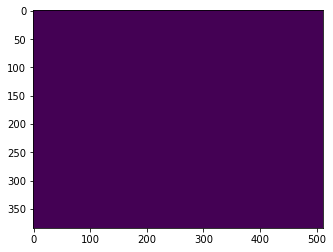

In [9]:
plt.imshow(stem_msk)

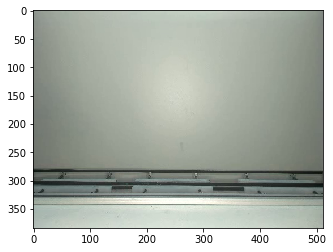

In [10]:
plt.imshow(img)

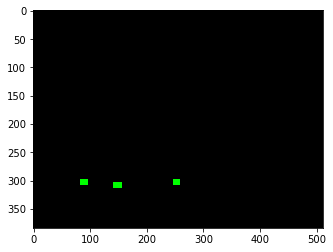

In [11]:
plt.imshow(colorir(msk))